In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
from fastai import *
import os
from collections import defaultdict

### Set up paths

In [2]:
train_pd = pd.read_csv('/root/.fastai/data/severstal/train.csv')

In [3]:
train_pd.head(5)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [4]:
path = Path('/root/.fastai/data/severstal')

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/severstal/train_images.zip'),
 PosixPath('/root/.fastai/data/severstal/sample_submission.csv'),
 PosixPath('/root/.fastai/data/severstal/test_images.zip'),
 PosixPath('/root/.fastai/data/severstal/train.csv'),
 PosixPath('/root/.fastai/data/severstal/train_images'),
 PosixPath('/root/.fastai/data/severstal/test_images')]

In [6]:
train_images = get_image_files(path/'train_images')
train_images[:3]

[PosixPath('/root/.fastai/data/severstal/train_images/5e581254c.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/fd2f7b4f4.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/82f4c0b69.jpg')]

### Check maximum size of images

In [7]:
def check_img_max_size(folder):
    max_height = 0
    max_width = 0
    for train_image in train_images:
        img = open_image(train_image)
        if max_height < img.shape[1]:
            max_height = img.shape[1]
        if max_width < img.shape[2]:
            max_width = img.shape[2]
    return max_height, max_width

def show_image(images, index):
    img_f = images[index]
    print(type(img_f))
    img = open_image(img_f)
    print(img)
    img.show(figsize=(5,5))

In [8]:
mask_path = Path('/kaggle/mask')
if not os.path.exists(mask_path):
    os.makedirs(str(mask_path))

In [9]:
def convert_encoded_to_array(encoded_pixels):
    pos_array = []
    len_array = []
    splits = encoded_pixels.split()
    pos_array = [int(n) - 1 for i, n in enumerate(splits) if i % 2 == 0]
    len_array = [int(n) for i, n in enumerate(splits) if i % 2 == 1]
    return pos_array, len_array
        
def convert_to_pair(pos_array, rows):
    return [(p % rows, p // rows) for p in pos_array]

def create_positions(single_pos, size):
    return [i for i in range(single_pos, single_pos + size)]

def create_positions_pairs(single_pos, size, row_size):
    return convert_to_pair(create_positions(single_pos, size), row_size)

def convert_to_mask(encoded_pixels, row_size, col_size, category):
    pos_array, len_array = convert_encoded_to_array(encoded_pixels)
    mask = np.zeros([row_size, col_size])
    for(p, l) in zip(pos_array, len_array):
        for row, col in create_positions_pairs(p, l, row_size):
            mask[row][col] = category
    return mask

def save_to_image(masked, image_name):
    im = PIL.Image.fromarray(masked)
    im = im.convert("L")
    image_name = re.sub(r'(.+)\.jpg', r'\1', image_name) + ".png"
    real_path = mask_path/image_name
    im.save(real_path)
    return real_path

def open_single_image(path):
    img = open_image(path)
    img.show(figsize=(20,20))
    
def get_y_fn(x):
    return mask_path/(x.stem + '.png')

def group_by(train_images, train_pd):
    tran_dict = {image.name:[] for image in train_images}
    pattern = re.compile('(.+)_(\d+)')
    for index, image_path in train_pd.iterrows():
        m = pattern.match(image_path['ImageId_ClassId'])
        file_name = m.group(1)
        category = m.group(2)
        tran_dict[file_name].append((int(category), image_path['EncodedPixels']))
    return tran_dict

def display_image_with_mask(img_name):
    full_image = path/'train_images'/img_name
    print(full_image)
    open_single_image(full_image)
    mask_image = get_y_fn(full_image)
    mask = open_mask(mask_image)
    print(full_image)
    mask.show(figsize=(20, 20), alpha=0.5)

In [10]:
grouped_categories_mask = group_by(train_images, train_pd)

### Create mask files and save these to kaggle/mask/

In [11]:
image_height = 256
image_width = 1600
if not os.path.exists(mask_path/'0002cc93b.png'):
    for image_name, cat_list in grouped_categories_mask.items():
        masked = np.zeros([image_height, image_width])
        for cat_mask in cat_list:
            encoded_pixels = cat_mask[1]
            if pd.notna(cat_mask[1]):
                masked += convert_to_mask(encoded_pixels, image_height, image_width, cat_mask[0])
        if np.amax(masked) > 4:
            print(f'Check {image_name} for max category {np.amax(masked)}')
        save_to_image(masked, image_name)

### Prepare Transforms

In [12]:
def limited_dihedral_affine(k:partial(uniform_int,0,3)):
    "Randomly flip `x` image based on `k`."
    x = -1 if k&1 else 1
    y = -1 if k&2 else 1
    if k&4: return [[0, x, 0.],
                    [y, 0, 0],
                    [0, 0, 1.]]
    return [[x, 0, 0.],
            [0, y, 0],
            [0, 0, 1.]]

dihedral_affine = TfmAffine(limited_dihedral_affine)

def get_extra_transforms(max_rotate:float=3., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    p_lightings = [p_lighting, p_lighting + 0.2, p_lighting + 0.4, p_lighting + 0.6, p_lighting + 0.7]
    max_lightings = [max_lighting, max_lighting + 0.2, max_lighting + 0.4, max_lighting + 0.6, max_lighting + 0.7]
    res = [rand_crop(), dihedral_affine(), 
           symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine),
           rotate(degrees=(-max_rotate,max_rotate), p=p_affine),
           rand_zoom(scale=(1., max_zoom), p=p_affine)]
    res.extend([brightness(change=(0.5*(1-mp[0]), 0.5*(1+mp[0])), p=mp[1]) for mp in zip(max_lightings, p_lightings)])
    res.extend([contrast(scale=(1-mp[0], 1/(1-mp[0])), p=mp[1]) for mp in zip(max_lightings, p_lightings)])
    #       train                   , valid
    return (res, [crop_pad()])

def get_simple_transforms(max_rotate:float=3., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [
        rand_crop(),
        symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine),
        rotate(degrees=(-max_rotate,max_rotate), p=p_affine),
        rand_zoom(scale=(1., max_zoom), p=p_affine)
          ]
    #       train                   , valid
    return (res, [crop_pad()])

### Prepare data bunch

In [13]:
train_images = (path/'train_images').ls()
src_size = np.array(open_image(str(train_images[0])).shape[1:])
valid_pct = 0.10

In [14]:
codes = array(['0', '1', '2', '3', '4'])

In [15]:
src = (SegmentationItemList.from_folder(path/'train_images')
       .split_by_rand_pct(valid_pct=valid_pct)
       .label_from_func(get_y_fn, classes=codes))

In [16]:
bs = 4
size = src_size//4

In [17]:
data = (src.transform(get_simple_transforms(), size=size, tfm_y=True)
        .add_test(ImageList.from_folder(path/'test_images'), tfms=None, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

### Create learner and training
Starting with low resolution training

##### Some metrics functions

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['0']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    argmax = (input.argmax(dim=1))
    comparison = argmax[mask]==target[mask]
    return torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()

def acc_camvid_with_zero_check(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        if(torch.sum(argmax[b]).item() == 0.0 and torch.sum(target[b]).item() == 0.0):
            total[b] = 1
        else:
            mask = target[b] != void_code
            comparison = argmax[b][mask]==target[b][mask]
            total[b] = torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()
    return total.mean()


def calc_dice_coefficients(argmax, target, cats):
    def calc_dice_coefficient(seg, gt, cat: int):
        mask_seg = seg == cat
        mask_gt = gt == cat
        sum_seg = torch.sum(mask_seg.float())
        sum_gt = torch.sum(mask_gt.float())
        if sum_seg + sum_gt == 0:
            return torch.tensor(1.0)
        return (torch.sum((seg[gt == cat] / cat).float()) * 2.0) / (sum_seg + sum_gt)

    total_avg = torch.empty([len(cats)])
    for i, c in enumerate(cats):
        total_avg[i] = calc_dice_coefficient(argmax, target, c)
    return total_avg.mean()


def dice_coefficient(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    cats = [1, 2, 3, 4]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        total[b] = calc_dice_coefficients(argmax[b], target[b], cats)
    return total.mean()

def calc_dice_coefficients_2(argmax, target, cats):
    def calc_dice_coefficient(seg, gt, cat: int):
        mask_seg = seg == cat
        mask_gt = gt == cat
        sum_seg = torch.sum(mask_seg.float())
        sum_gt = torch.sum(mask_gt.float())
        return (torch.sum((seg[gt == cat] / cat).float())), (sum_seg + sum_gt)

    total_avg = torch.empty([len(cats), 2])
    for i, c in enumerate(cats):
        total_avg[i][0], total_avg[i][1] = calc_dice_coefficient(argmax, target, c)
    total_sum = total_avg.sum(axis=0)
    if (total_sum[1] == 0.0):
        return torch.tensor(1.0)
    return total_sum[0] * 2.0 / total_sum[1]


def dice_coefficient_2(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    cats = [1, 2, 3, 4]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        total[b] = calc_dice_coefficients_2(argmax[b], target[b], cats)
    return total.mean()


def accuracy_simple(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()


def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

### Customized loss function

In [19]:
class CombinedCrossEntropyFlat():
    "Same as `func`, but flattens input and target."
    def __init__(self):
        self.func = nn.CrossEntropyLoss(weight=torch.tensor([2.0, .5, .5, .5, .5])).cuda()

    def __repr__(self): return f"CombinedCrossEntropyFlat"
    
    def dice_loss(self, target, output, eps=1e-7):
        """Computes the Sørensen–Dice loss.
        Note that PyTorch optimizers minimize a loss. In this
        case, we would like to maximize the dice loss so we
        return the negated dice loss.
        Args:
            target: a tensor of shape [B, 1, H, W].
            output: a tensor of shape [B, C, H, W]. Corresponds to
                the raw output or logits of the model.
            eps: added to the denominator for numerical stability.
        Returns:
            dice_loss: the Sørensen–Dice loss.
        """
        # skip the batch and class axis for calculating Dice score
        num_classes = output.shape[1]
        y_true = F.one_hot(target.long().squeeze(), num_classes)
        y_pred = F.softmax(output, dim=1).permute(0, 2, 3, 1)
        y_true = y_true.type(y_pred.type())
        axes = tuple(range(1, len(y_pred.shape)-1))
        numerator = 2. * torch.sum(y_pred * y_true, axes)
        denominator = torch.sum(y_pred ** 2 + y_true ** 2, axes)
        # When intersection and cardinality are all zero you have 100% score and not 0% score
        # For this we use the eps parameter
        loss_array = ((numerator + eps) / (denominator + eps))
        loss_array = (loss_array).mean(dim=0)
        return (1 - torch.mean(loss_array))


    def convert_max_to_one_hot(self, tensor1):
        tensor1_shape = tensor1.shape
        tensor1_input_view = tensor1.view(tensor1_shape[0], tensor1_shape[1], -1)
        return (tensor1_input_view == tensor1_input_view.max(dim = 1, keepdim=True)[0]).float().view_as(tensor1)
    
    
    def __call__(self, input:Tensor, target:Tensor)->Rank0Tensor:
        input_changed = input.transpose(1,-1).contiguous()
        target_changed = target.transpose(1,-1).contiguous()
        input_changed = input_changed.view(-1, input_changed.shape[-1])
        cel = self.func.__call__(input_changed, target_changed.view(-1))
        dice_loss = self.dice_loss(target, input)
#         print('dice_loss', cel, 'dice_loss', dice_loss)
        return cel

In [20]:
class DiceLoss(nn.Module):
    def __init__(self, zero_cat_factor=0.1):
        super().__init__()
        self.zero_cat_factor = zero_cat_factor

    def forward(self, input, target):
        return self.dice_loss(target, input, self.zero_cat_factor)

    def dice_loss(self, target, output, eps=1e-7, zero_cat_factor=0.1):
        '''
        Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
        Assumes the `channels_last` format.

        # Arguments
            target: b x 1 x X x Y( x Z...) ground truth
            output: b x c x X x Y( x Z...) Network output, must sum to 1 over c channel (such as after softmax)
            epsilon: Used for numerical stability to avoid divide by zero errors

        # References
            V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation
            https://arxiv.org/abs/1606.04797
            More details on Dice loss formulation
            https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)

            Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
        '''

        # skip the batch and class axis for calculating Dice score
        num_classes = output.shape[1]
        y_true = F.one_hot(target.long().squeeze(), num_classes)
        y_pred = F.softmax(output, dim=1).permute(0, 2, 3, 1)
        y_true = y_true.type(y_pred.type())
        y_true = y_true.permute(0, 3, 1, 2)
        y_true[:,0,:] *= zero_cat_factor # Factor used to take power away from the zeroth category
        y_true = y_true.permute(0, 2, 3, 1)
        axes = tuple(range(1, len(y_pred.shape)-1))
        numerator = 2. * torch.sum(y_pred * y_true, axes)
        denominator = torch.sum(y_pred ** 2 + y_true ** 2, axes)
        # When intersection and cardinality are all zero you have 100% score and not 0% score
        # For this we use the eps parameter
        loss_array = ((numerator + eps) / (denominator + eps))
        loss_array = (loss_array).mean(dim=0)
        return ((1 - torch.mean(loss_array)) + F.cross_entropy(output, target.squeeze())) / 2.

    def __del__(self): pass

In [21]:
class DiceLoss2(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        return self.dice_loss(target, input)

    def dice_loss(self, true, logits):
        num_classes = logits.shape[1]
        true_1_hot = F.one_hot(true.long().squeeze(), num_classes)
        true_1_hot = true_1_hot.permute(0, 3, 1, 2)
        return self.dice_loss_encoded(logits, true_1_hot.float())

    def dice_loss_encoded(self, input, target, eps=1e-7):
        """
        input is a torch variable of size BatchxnclassesxHxW representing log probabilities for each class
        target is a 1-hot representation of the groundtruth, shoud have same size as the input
        """
        assert input.size() == target.size(), "Input sizes must be equal."
        assert input.dim() == 4, "Input must be a 4D Tensor."

        probs = F.softmax(input, dim=1)
        num = probs * target  # b,c,h,w--p*g
        num = torch.sum(num, dim=3)  # b,c,h
        num = torch.sum(num, dim=2)

        den1 = probs * probs  # --p^2
        den1 = torch.sum(den1, dim=3)  # b,c,h
        den1 = torch.sum(den1, dim=2)

        den2 = target * target  # --g^2
        den2 = torch.sum(den2, dim=3)  # b,c,h
        den2 = torch.sum(den2, dim=2)  # b,c

        dice = 2 * ((num + eps) / (den1 + den2 + eps))
        dice_eso = dice * torch.tensor([0.01, 1.0, 1.0, 1.0, 1.0]).cuda()

        dice_total = -1 * torch.sum(dice_eso) / dice_eso.size(0)  # divide by batch_sz

        return dice_total

    def __del__(self): pass

In [22]:
from torch.autograd import Variable

class WeightedCrossEntropyLoss(nn.Module):
    """WeightedCrossEntropyLoss (WCE) as described in https://arxiv.org/pdf/1707.03237.pdf
    """

    def __init__(self, weight=None, ignore_index=-1):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index

    def forward(self, input, target):
        class_weights = self._class_weights(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False)
            class_weights = class_weights * weight
        return F.cross_entropy(input, target.squeeze(), weight=class_weights, ignore_index=self.ignore_index)

    @staticmethod
    def _class_weights(input):
        # normalize the input first
        input = F.softmax(input, dim=1)
        flattened = flatten(input)
        nominator = (1. - flattened).sum(-1)
        denominator = flattened.sum(-1)
        class_weights = Variable(nominator / denominator, requires_grad=False)
        return class_weights
    
def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.reshape(C, -1)

In [23]:
from itertools import filterfalse

class LovaszSoftmax(nn.Module):
    """WeightedCrossEntropyLoss (WCE) as described in https://arxiv.org/pdf/1707.03237.pdf
    """

    def __init__(self, weight=None, ignore_index=-1, only_present=False, per_image=False):
        super(LovaszSoftmax, self).__init__()
        self.register_buffer('weight', weight)
        self.only_present = only_present
        self.per_image = per_image
        self.ignore_index = ignore_index

    def forward(self, input, target):
        return (lovasz_softmax(input, target) + F.cross_entropy(input, target.squeeze())) / 2.


def lovasz_softmax(probas, labels, only_present=False, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(
            lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), only_present=only_present)
            for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), only_present=only_present)
    return loss


def lovasz_softmax_flat(probas, labels, only_present=False):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    C = probas.size(1)
    losses = []
    for c in range(C):
        fg = (labels == c).float()  # foreground for class c
        if only_present and fg.sum() == 0:
            continue
        errors = (Variable(fg) - probas[:, c]).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels


def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = filterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

##### The main training function

In [24]:
from fastai import callbacks

def train_learner(learn, slice_lr, epochs=10, pct_start=0.8, best_model_name='best_model', 
                  patience_early_stop=4, patience_reduce_lr = 3):
    learn.fit_one_cycle(epochs, slice_lr, pct_start=pct_start, 
                    callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max', name=best_model_name),
                              callbacks.EarlyStoppingCallback(learn=learn, monitor='dice_coefficient', patience=patience_early_stop),
                              callbacks.ReduceLROnPlateauCallback(learn=learn, monitor='dice_coefficient', patience=patience_reduce_lr),
                              callbacks.TerminateOnNaNCallback()])

In [73]:
metrics=accuracy_simple, acc_camvid_with_zero_check, dice_coefficient, dice_coefficient_2
wd=1e-2

In [74]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
# learn.loss_func = CrossEntropyFlat(axis=1, weight=torch.tensor([0.5, .5, .5, .5, .5]).cuda())
learn.loss_func = DiceLoss(zero_cat_factor=0.5)
# learn.loss_func = DiceLoss2()
# learn.loss_func = CombinedCrossEntropyFlat()
# learn.loss_func = WeightedCrossEntropyLoss(weight=torch.tensor([5.0, 1.0, 1.0, 1.0, 1.0]).cuda())
# learn.loss_func = LovaszSoftmax()
learn.loss_func

DiceLoss()

In [75]:
learn.model_dir = Path('/kaggle/model')

In [76]:
# learn = to_fp16(learn, loss_scale=4.0)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


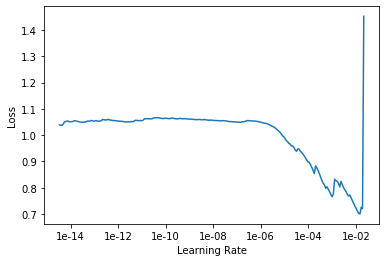

In [77]:
lr_find(learn, num_it=300, start_lr=1e-15)
learn.recorder.plot()

In [78]:
lr=5e-05

In [79]:
train_learner(learn, slice(lr), epochs=10, pct_start=0.8, best_model_name='bestmodel-frozen-1', 
              patience_early_stop=6, patience_reduce_lr = 5)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,dice_coefficient_2,time
0,0.230642,0.219718,0.971246,0.476696,0.861453,0.490468,03:50
1,0.226786,0.196859,0.973422,0.525597,0.872506,0.547085,03:47
2,0.200960,0.186551,0.974812,0.559489,0.879826,0.577969,03:48
3,0.212574,0.186421,0.975123,0.556733,0.883266,0.574208,03:49
4,0.183602,0.172575,0.976693,0.604497,0.893125,0.615918,03:47
5,0.186880,0.169757,0.976251,0.594451,0.888628,0.618843,03:48
6,0.178143,0.164044,0.978652,0.626104,0.899730,0.641866,03:49
7,0.181306,0.163311,0.978841,0.651109,0.902313,0.649704,03:48
8,0.166421,0.152213,0.980182,0.681407,0.911982,0.684589,03:52
9,0.162767,0.148781,0.980392,0.680607,0.912024,0.686573,03:48


Better model found at epoch 0 with dice_coefficient value: 0.8614534139633179.
Better model found at epoch 1 with dice_coefficient value: 0.8725060820579529.
Better model found at epoch 2 with dice_coefficient value: 0.8798258304595947.
Better model found at epoch 3 with dice_coefficient value: 0.8832660913467407.
Better model found at epoch 4 with dice_coefficient value: 0.8931249380111694.
Better model found at epoch 6 with dice_coefficient value: 0.8997301459312439.
Better model found at epoch 7 with dice_coefficient value: 0.9023130536079407.
Better model found at epoch 8 with dice_coefficient value: 0.9119824171066284.
Better model found at epoch 9 with dice_coefficient value: 0.9120238423347473.


In [89]:
train_learner(learn, slice(lr), epochs=10, pct_start=0.8, best_model_name='bestmodel-frozen-1', 
              patience_early_stop=6, patience_reduce_lr = 5)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,dice_coefficient_2,time


KeyboardInterrupt: 

In [80]:
learn.save('stage-1')

In [90]:
learn.load('stage-1');

In [63]:
# learn.load('bestmodel-frozen-1');

In [82]:
learn.export(file='/kaggle/model/export-1.pkl')

/opt/conda/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DiceLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [232]:
# learn.loss_func = CrossEntropyFlat(axis=1, weight=torch.tensor([2.0, .5, .5, .5, .5]).cuda())

In [91]:
learn.unfreeze()

In [92]:
lrs = slice(lr/100,lr)

In [93]:
train_learner(learn, lrs, epochs=10, pct_start=0.8, best_model_name='bestmodel-unfrozen-1', 
              patience_early_stop=4, patience_reduce_lr = 3)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,dice_coefficient_2,time
0,0.156744,0.148068,0.980871,0.681281,0.912305,0.689429,04:20
1,0.157174,0.148648,0.980662,0.683574,0.913950,0.692229,04:18
2,0.164563,0.148989,0.979793,0.709058,0.916540,0.706128,04:16
3,0.164204,0.146476,0.980741,0.709276,0.915675,0.707042,04:19
4,0.166017,0.149200,0.980371,0.699878,0.911862,0.694906,04:19
5,0.171202,0.149906,0.979812,0.695506,0.912876,0.695331,04:20
6,0.164314,0.151201,0.980133,0.692852,0.918322,0.712290,04:23
7,0.156794,0.149286,0.980456,0.695175,0.913335,0.705666,04:20
8,0.148593,0.144776,0.979693,0.732916,0.920614,0.721482,04:20
9,0.143420,0.142453,0.981357,0.726625,0.921310,0.729977,04:23


Better model found at epoch 0 with dice_coefficient value: 0.912305474281311.
Better model found at epoch 1 with dice_coefficient value: 0.9139496684074402.
Better model found at epoch 2 with dice_coefficient value: 0.9165398478507996.
Better model found at epoch 6 with dice_coefficient value: 0.9183222055435181.
Better model found at epoch 8 with dice_coefficient value: 0.9206141829490662.
Better model found at epoch 9 with dice_coefficient value: 0.9213098287582397.


In [94]:
learn.save('stage-2');

In [34]:
learn.load('bestmodel-unfrozen-1');

In [95]:
learn.export(file='/kaggle/model/export-2.pkl')

/opt/conda/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DiceLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Go Large

In [22]:
bs=2

In [23]:
def create_large_learner(bs=4, transform_func=get_extra_transforms, model_to_load='bestmodel-unfrozen-1'):
    src = (SegmentationItemList.from_folder(path/'train_images')
       .split_by_rand_pct(valid_pct=valid_pct)
       .label_from_func(get_y_fn, classes=codes))
    data = (src.transform(transform_func(), size=src_size, tfm_y=True)
        .add_test(ImageList.from_folder(path/'test_images'), tfms=None, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
    learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
    learn.model_dir = Path('/kaggle/model')
    learn.loss_func = CrossEntropyFlat(axis=1, weight=torch.tensor([2.0, .5, .5, .5, .5]).cuda())
    learn = to_fp16(learn, loss_scale=4.0)
    learn.load(model_to_load)
    return learn

In [26]:
learn = create_large_learner(bs=bs, transform_func=get_extra_transforms, model_to_load='bestmodel-unfrozen-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


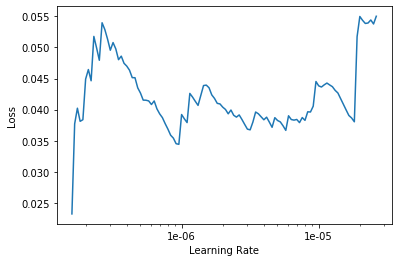

In [27]:
lr_find(learn, num_it=400)
learn.recorder.plot()

In [24]:
lr=1e-06

In [30]:
train_learner(learn, slice(lr), epochs=8, pct_start=0.8, best_model_name='bestmodel-frozen-3', 
              patience_early_stop=4, patience_reduce_lr = 3)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,dice_coefficient_2,time
0,0.064356,0.063455,0.964433,0.452251,0.852917,0.452272,56:09
1,0.055913,0.061035,0.964429,0.468153,0.857882,0.468154,56:33
2,0.049120,0.058670,0.964438,0.453115,0.854144,0.453202,56:44
3,0.048207,0.059026,0.964450,0.454092,0.854425,0.454323,56:47
4,0.030677,0.063129,0.964466,0.458232,0.855491,0.458589,56:50
5,0.044698,0.051799,0.964528,0.457419,0.854842,0.458380,56:53


Better model found at epoch 0 with dice_coefficient value: 0.8529166579246521.
Better model found at epoch 1 with dice_coefficient value: 0.8578823804855347.
Epoch 5: reducing lr to 1.9815599641068586e-07
Epoch 6: early stopping


In [31]:
learn.save('stage-3');

In [32]:
learn.load('bestmodel-frozen-3');

In [43]:
learn.export(file='/kaggle/model/export-3.pkl')

In [25]:
learn = create_large_learner(bs=bs, transform_func=get_extra_transforms, model_to_load='bestmodel-frozen-3')

In [26]:
learn.unfreeze()

In [27]:
lrs = slice(lr/1000,lr/10)

In [28]:
train_learner(learn, lrs, epochs=10, pct_start=0.8, best_model_name='bestmodel-4', 
              patience_early_stop=5, patience_reduce_lr = 3)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,dice_coefficient_2,time
0,0.046043,0.055464,0.968823,0.479300,0.861067,0.479300,58:35
1,0.057401,0.051552,0.968823,0.480892,0.861465,0.480892,58:29
2,0.043538,0.053718,0.968823,0.480096,0.861266,0.480097,58:35
3,0.055197,0.053127,0.968823,0.478505,0.860869,0.478508,58:33
4,0.052151,0.050433,0.968823,0.479300,0.861067,0.479301,58:36
5,0.057375,0.051997,0.968824,0.476124,0.860275,0.476133,58:34
6,0.048061,0.053134,0.968827,0.469777,0.858694,0.469808,58:42


Better model found at epoch 0 with dice_coefficient value: 0.861066997051239.
Better model found at epoch 1 with dice_coefficient value: 0.8614651560783386.
Epoch 5: reducing lr to 1.7188225099390853e-08


KeyboardInterrupt: 

In [ ]:
learn.save('stage-4');

In [ ]:
learn.load('bestmodel-4');

In [29]:
learn.export(file='/kaggle/model/export-4.pkl')

In [ ]:
!pwd
!cp /kaggle/model/export.pkl /opt/fastai/fastai-exercises/nbs_gil
from IPython.display import FileLink
FileLink(r'export-4.pkl')

### Inference

In [347]:
learn=None
gc.collect()

40

In [96]:
test_images = (path/'test_images').ls()

In [97]:
!mv /kaggle/model/export-2.pkl /kaggle/model/export.pkl 

In [98]:
inference_learn = load_learner('/kaggle/model/')

In [99]:
def predict(img_path):
    pred_class, pred_idx, outputs = inference_learn.predict(open_image(str(img_path)))
    return pred_class, pred_idx, outputs

def encode_classes(pred_class_data):
    pixels = np.concatenate([[0], torch.transpose(pred_class_data.squeeze(), 0, 1).flatten(), [0]])
    classes_dict = {1: [], 2: [], 3: [], 4: []}
    count = 0
    previous = pixels[0]
    for i, val in enumerate(pixels):
        if val != previous:
            if previous in classes_dict:
                classes_dict[previous].append((i - count, count))
            count = 0
        previous = val
        count += 1
    return classes_dict


def convert_classes_to_text(classes_dict, clazz):
    return ' '.join([f'{v[0]} {v[1]}' for v in classes_dict[clazz]])

/root/.fastai/data/severstal/train_images/8f5e37d0a.jpg
/root/.fastai/data/severstal/train_images/8f5e37d0a.jpg


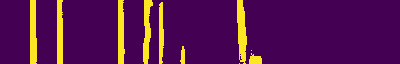

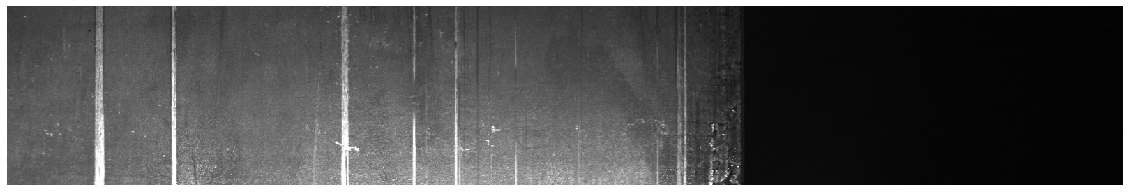

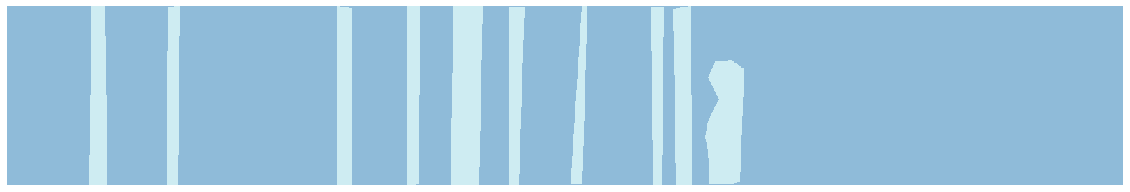

In [103]:
image_to_predict = train_images[13].name
display_image_with_mask(image_to_predict)
pred_class, pred_idx, outputs = predict(path/f'train_images/{image_to_predict}')
pred_class

In [ ]:
torch.transpose(pred_class.data.squeeze(), 0, 1).shape

#### Checking encoding methods

In [ ]:
encoded_all = encode_classes(pred_class.data)
print(convert_classes_to_text(encoded_all, 3))

In [ ]:
image_name = train_images[16]
print(get_y_fn(image_name))
img = open_mask(get_y_fn(image_name))
img_data = img.data
print(convert_classes_to_text(encode_classes(img_data), 3))
img_data.shape

### Loop through the test images and create submission csv

In [ ]:
import time
start_time = time.time()

defect_classes = [1, 2, 3, 4]
with open('submission.csv', 'w') as submission_file:
    submission_file.write('ImageId_ClassId,EncodedPixels\n')
    for i, test_image in enumerate(test_images):
        pred_class, pred_idx, outputs = predict(test_image)
        encoded_all = encode_classes(pred_class.data)
        for defect_class in defect_classes:
            submission_file.write(f'{test_image.name}_{defect_class},{convert_classes_to_text(encoded_all, defect_class)}\n')
        if i % 5 == 0:
            print(f'Processed {i} images\r', end='')
            
print(f"--- {time.time() - start_time} seconds ---")

### Alternative prediction methods

In [ ]:
preds,y = learn.get_preds(ds_type=DatasetType.Test, with_loss=False)

In [ ]:
preds.shape

In [ ]:
pred_class_data = preds.argmax(dim=1)

In [ ]:
len((path/'test_images').ls())

In [ ]:
data.test_ds.x